In [2]:
# CELL 0 — Imports and data loading

import numpy as np
import pandas as pd
from scipy.stats import invgamma, multivariate_normal
import matplotlib.pyplot as plt
from texas_gerrymandering_hb4.config import FINAL_CSV

plt.rcParams["figure.figsize"] = (7, 5)

df = pd.read_csv(FINAL_CSV)
reg_results = pd.read_csv("regression_results.csv")
mix_results = pd.read_csv("mixture_results.csv")

# Merge everything on district_id
merged = df.merge(reg_results, on=["district_id", "dem_share"])
merged = merged.merge(mix_results, on=["district_id", "dem_share"])

merged.head()


,district_id,polsby_popper,schwartzberg,convex_hull_ratio,reock,pct_white,pct_black,pct_asian,pct_hispanic,dem_share,rep_share,pp_mean_dem_share,pp_resid_dem_share,mix_comp,p_comp1
0,1,0.193575,0.439971,0.722970,0.407570,0.632532,0.184984,0.014875,0.142830,0.252671,0.728964,0.352764,-0.100092,1,0.616267
1,2,0.165232,0.406487,0.625270,0.417351,0.526751,0.125050,0.072934,0.255189,0.399379,0.577517,0.445549,-0.046170,1,0.622200
2,3,0.216761,0.465576,0.805445,0.273916,0.577914,0.112669,0.111327,0.172895,0.403698,0.573637,0.409745,-0.006048,1,0.621600
3,4,0.103462,0.321654,0.574190,0.222752,0.605524,0.099241,0.157600,0.108877,0.405732,0.575123,0.423061,-0.017329,1,0.618533
4,5,0.184465,0.429494,0.823171,0.310183,0.522819,0.159980,0.034848,0.261670,0.481179,0.498040,0.405767,0.075412,1,0.619133


In [3]:
# CELL 1 — Quick checks and definitions

merged.columns


Index(['district_id', 'polsby_popper', 'schwartzberg', 'convex_hull_ratio',
       'reock', 'pct_white', 'pct_black', 'pct_asian', 'pct_hispanic',
       'dem_share', 'rep_share', 'pp_mean_dem_share', 'pp_resid_dem_share',
       'mix_comp', 'p_comp1'],
      dtype='object')

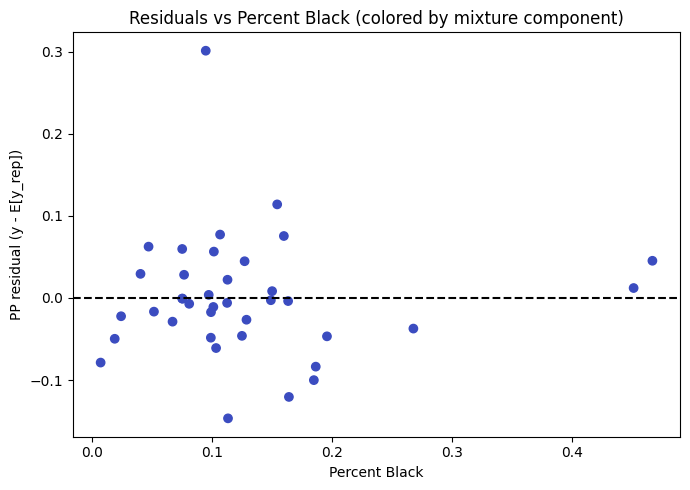

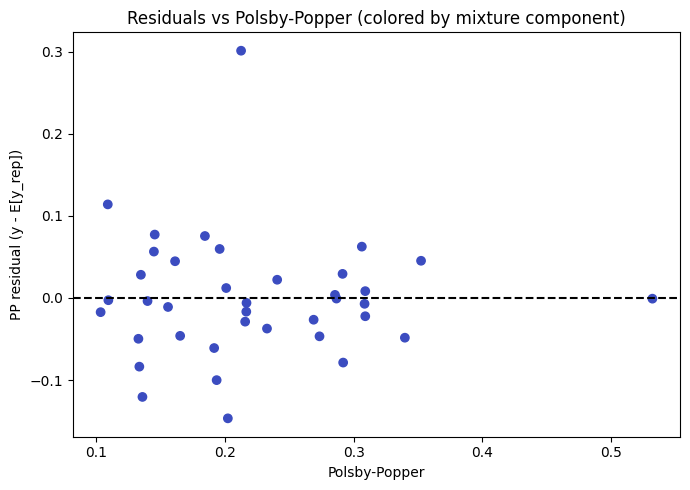

In [4]:
# CELL 2 — Scatter plots: residuals vs race and compactness, colored by mixture component

pp_resid = merged["pp_resid_dem_share"].values

plt.scatter(merged["pct_black"], pp_resid, c=merged["mix_comp"], cmap="coolwarm")
plt.axhline(0.0, color="k", linestyle="--")
plt.xlabel("Percent Black")
plt.ylabel("PP residual (y - E[y_rep])")
plt.title("Residuals vs Percent Black (colored by mixture component)")
plt.tight_layout()
plt.show()

plt.scatter(merged["polsby_popper"], pp_resid, c=merged["mix_comp"], cmap="coolwarm")
plt.axhline(0.0, color="k", linestyle="--")
plt.xlabel("Polsby-Popper")
plt.ylabel("PP residual (y - E[y_rep])")
plt.title("Residuals vs Polsby-Popper (colored by mixture component)")
plt.tight_layout()
plt.show()


In [5]:
# CELL 3 — Second-stage regression: residuals ~ compactness

r = merged["pp_resid_dem_share"].values
n = len(r)

Z_raw = merged[["polsby_popper", "reock", "schwartzberg"]].values
Z_mean = Z_raw.mean(axis=0)
Z_std = Z_raw.std(axis=0, ddof=1)
Z_std[Z_std == 0] = 1.0
Z_stdzd = (Z_raw - Z_mean) / Z_std

Z = np.column_stack([np.ones(n), Z_stdzd])
q = Z.shape[1]

gamma0 = np.zeros(q)
tau2_gamma = 10.0**2
W0 = tau2_gamma * np.eye(q)

alpha0_r = 2.0
beta0_r = 1.0

gamma_curr = np.zeros(q)
tau2_curr = 1.0

n_iter_r = 15000
burn_in_r = 5000

gamma_samples = np.zeros((n_iter_r, q))
tau2_samples = np.zeros(n_iter_r)

ZtZ = Z.T @ Z
Ztr = Z.T @ r
W0_inv = np.linalg.inv(W0)

for it in range(n_iter_r):
    # gamma | tau2, r
    Wn_inv = ZtZ / tau2_curr + W0_inv
    Wn = np.linalg.inv(Wn_inv)
    gn = Wn @ (Ztr / tau2_curr + W0_inv @ gamma0)
    gamma_curr = multivariate_normal.rvs(mean=gn, cov=Wn)

    # tau2 | gamma, r
    res_r = r - Z @ gamma_curr
    alpha_n_r = alpha0_r + n / 2.0
    beta_n_r = beta0_r + 0.5 * (res_r @ res_r)
    tau2_curr = invgamma.rvs(a=alpha_n_r, scale=beta_n_r)

    gamma_samples[it, :] = gamma_curr
    tau2_samples[it] = tau2_curr

gamma_post = gamma_samples[burn_in_r:, :]
tau2_post = tau2_samples[burn_in_r:]

gamma_summary = []
for j, name in enumerate(["intercept", "polsby_popper", "reock", "schwartzberg"]):
    row = {
        "parameter": name,
        "mean": gamma_post[:, j].mean(),
        "2.5%": np.quantile(gamma_post[:, j], 0.025),
        "50%": np.quantile(gamma_post[:, j], 0.5),
        "97.5%": np.quantile(gamma_post[:, j], 0.975),
    }
    gamma_summary.append(row)

pd.DataFrame(gamma_summary)


,parameter,mean,2.5%,50%,97.5%
0,intercept,-0.001123,-0.079987,-0.001553,0.078622
1,polsby_popper,0.004590,-0.654673,0.005278,0.649153
2,reock,0.001117,-0.103880,0.000943,0.108627
3,schwartzberg,-0.006524,-0.661520,-0.007352,0.667571


In [6]:
# CELL 4 — Regression: p_comp1 ~ race + compactness

p_resp = merged["p_comp1"].values

W_raw = merged[[
    "pct_black",
    "pct_hispanic",
    "pct_asian",
    "polsby_popper",
    "reock",
    "schwartzberg",
]].values

W_mean = W_raw.mean(axis=0)
W_std = W_raw.std(axis=0, ddof=1)
W_std[W_std == 0] = 1.0
W_stdzd = (W_raw - W_mean) / W_std

W = np.column_stack([np.ones(n), W_stdzd])
r_dim = W.shape[1]

delta0 = np.zeros(r_dim)
tau2_delta = 10.0**2
R0 = tau2_delta * np.eye(r_dim)

alpha0_p = 2.0
beta0_p = 1.0

delta_curr = np.zeros(r_dim)
omega2_curr = 0.1

n_iter_p = 15000
burn_in_p = 5000

delta_samples = np.zeros((n_iter_p, r_dim))
omega2_samples = np.zeros(n_iter_p)

WtW = W.T @ W
Wtp = W.T @ p_resp
R0_inv = np.linalg.inv(R0)

for it in range(n_iter_p):
    Rn_inv = WtW / omega2_curr + R0_inv
    Rn = np.linalg.inv(Rn_inv)
    dn = Rn @ (Wtp / omega2_curr + R0_inv @ delta0)
    delta_curr = multivariate_normal.rvs(mean=dn, cov=Rn)

    res_p = p_resp - W @ delta_curr
    alpha_n_p = alpha0_p + n / 2.0
    beta_n_p = beta0_p + 0.5 * (res_p @ res_p)
    omega2_curr = invgamma.rvs(a=alpha_n_p, scale=beta_n_p)

    delta_samples[it, :] = delta_curr
    omega2_samples[it] = omega2_curr

delta_post = delta_samples[burn_in_p:, :]
omega2_post = omega2_samples[burn_in_p:]

delta_summary = []
for j, name in enumerate(
    ["intercept", "pct_black", "pct_hispanic", "pct_asian", "polsby_popper", "reock", "schwartzberg"]
):
    row = {
        "parameter": name,
        "mean": delta_post[:, j].mean(),
        "2.5%": np.quantile(delta_post[:, j], 0.025),
        "50%": np.quantile(delta_post[:, j], 0.5),
        "97.5%": np.quantile(delta_post[:, j], 0.975),
    }
    delta_summary.append(row)

pd.DataFrame(delta_summary)


,parameter,mean,2.5%,50%,97.5%
0,intercept,0.620964,0.541904,0.621154,0.699455
1,pct_black,-0.001895,-0.085947,-0.001848,0.081291
2,pct_hispanic,-0.000174,-0.099828,-0.000309,0.101926
3,pct_asian,0.000672,-0.108544,0.000950,0.108563
4,polsby_popper,-0.009654,-0.657776,-0.010391,0.635041
5,reock,0.000826,-0.104626,0.001214,0.106407
6,schwartzberg,0.009713,-0.659230,0.012287,0.680358
